# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
# when running in Udacity workspace
!pip -q install ./python

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
from maddpg_agent import Agent
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
from unityagents import UnityEnvironment

%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
## when running locally
env = UnityEnvironment(file_name='Tennis.app')

## when running via AWS EC2
# env = UnityEnvironment(file_name='Reacher_Linux_NoVis/Reacher.x86_64')

## when running in Udacity workspace
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [7]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.09000000171363354
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.10000000149011612


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
# MADDPG function

def maddpg(n_episodes=3000, max_t=1000, solved_score=0.5, consec_episodes=100, print_every=1, train_mode=True,
         actor_0_path='actor_0_ckpt.pth', actor_1_path='actor_1_ckpt.pth', critic_path='critic_ckpt.pth'):
    """Multi-Agent Deep Deterministic Policy Gradient (MADDPG)
    
    Params
    ======
        n_episodes (int)      : maximum number of training episodes
        max_t (int)           : maximum number of timesteps per episode
        train_mode (bool)     : if 'True' set environment to training mode
        solved_score (float)  : min avg score over consecutive episodes
        consec_episodes (int) : number of consecutive episodes used to calculate score
        print_every (int)     : interval to display results
        actor_0_path (str)    : directory to store actor0 network weights
        actor_1_path (str)    : directory to store actor1 network weights
        critic_path (str)     : directory to store shared critic network weights

    """
    mean_scores = []                               # list of mean scores from each episode
    min_scores = []                                # list of lowest scores from each episode
    max_scores = []                                # list of highest scores from each episode
    best_score = -np.inf
    scores_window = deque(maxlen=consec_episodes)  # mean scores from most recent episodes
    moving_avgs = []                               # list of moving averages
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name] # reset environment
        states = env_info.vector_observations                   # get current state for each agent      
        scores = np.zeros(num_agents)                           # initialize score for each agent
        agent.reset()
        start_time = time.time()
        for t in range(max_t):
            actions = agent.act(states, add_noise=True)         # select an action for all agents
            env_info = env.step(actions)[brain_name]            # send actions to environment
            next_states = env_info.vector_observations          # get next state
            rewards = env_info.rewards                          # get reward
            dones = env_info.local_done                         # see if episode has finished
            # save experience to replay buffer, perform learning step at defined interval
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)             
            states = next_states
            scores += rewards        
            if np.any(dones):                                   # exit loop when episode ends
                break

        duration = time.time() - start_time
        min_scores.append(np.min(scores))             # save lowest score for a single agent
        max_scores.append(np.max(scores))             # save highest score for a single agent        
        mean_scores.append(np.mean(scores))           # save mean score for the episode
        scores_window.append(mean_scores[-1])         # save mean score to window
        moving_avgs.append(np.mean(scores_window))    # save moving average
                
        if i_episode % print_every == 0:
            print('\rEpisode {} ({} sec)  -- \tMin: {:.1f}\tMax: {:.1f}\tMean: {:.1f}\tMov. Avg: {:.1f}'.format(\
                  i_episode, round(duration), min_scores[-1], max_scores[-1], mean_scores[-1], moving_avgs[-1]))
        
        if train_mode and mean_scores[-1] > best_score:
            torch.save(agent.actor_local.state_dict(), actor_path)
            torch.save(agent.critic_local.state_dict(), critic_path)
                  
        if moving_avgs[-1] >= solved_score and i_episode >= consec_episodes:
            print('\nEnvironment SOLVED in {} episodes!\tMoving Average ={:.1f} over last {} episodes'.format(\
                                    i_episode-consec_episodes, moving_avgs[-1], consec_episodes))            
            if train_mode:
                torch.save(agent.actor_local.state_dict(), actor_path)
                torch.save(agent.critic_local.state_dict(), critic_path)  
            break
            
    return mean_scores, moving_avgs

In [8]:
# run the training loop
agent = MultiAgent(state_size=state_size, action_size=action_size, num_agentsrandom_seed=1)
scores, avgs = maddpg()

Episode 1 (89 sec)  -- 	Min: 0.0	Max: 2.1	Mean: 0.6	Mov. Avg: 0.6
Episode 2 (92 sec)  -- 	Min: 0.0	Max: 2.3	Mean: 0.9	Mov. Avg: 0.8
Episode 3 (93 sec)  -- 	Min: 0.7	Max: 3.6	Mean: 2.0	Mov. Avg: 1.2
Episode 4 (94 sec)  -- 	Min: 0.7	Max: 4.8	Mean: 2.5	Mov. Avg: 1.5
Episode 5 (94 sec)  -- 	Min: 1.1	Max: 6.3	Mean: 2.9	Mov. Avg: 1.8
Episode 6 (96 sec)  -- 	Min: 2.5	Max: 7.3	Mean: 4.4	Mov. Avg: 2.2
Episode 7 (96 sec)  -- 	Min: 1.3	Max: 6.5	Mean: 3.5	Mov. Avg: 2.4
Episode 8 (97 sec)  -- 	Min: 2.6	Max: 11.5	Mean: 4.9	Mov. Avg: 2.7
Episode 9 (97 sec)  -- 	Min: 3.0	Max: 9.0	Mean: 5.8	Mov. Avg: 3.0
Episode 10 (98 sec)  -- 	Min: 2.9	Max: 9.8	Mean: 6.9	Mov. Avg: 3.4
Episode 11 (100 sec)  -- 	Min: 4.2	Max: 18.1	Mean: 8.1	Mov. Avg: 3.9
Episode 12 (101 sec)  -- 	Min: 4.3	Max: 12.9	Mean: 8.0	Mov. Avg: 4.2
Episode 13 (101 sec)  -- 	Min: 3.2	Max: 11.1	Mean: 7.2	Mov. Avg: 4.4
Episode 14 (103 sec)  -- 	Min: 2.7	Max: 18.8	Mean: 9.0	Mov. Avg: 4.8
Episode 15 (103 sec)  -- 	Min: 3.1	Max: 13.4	Mean: 8.3	Mov. Av

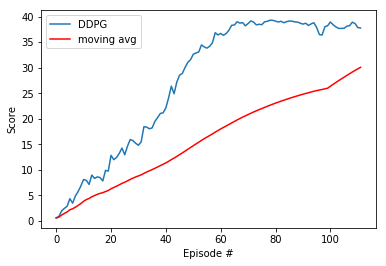

In [9]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='DDPG')
plt.plot(np.arange(len(scores)), avgs, c='r', label='moving avg')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

When finished, you can close the environment.

In [ ]:
env.close()